## Setting up

In [3]:
!pip install numpy
!pip install torch
!pip install tqdm
!pip install torchvision
!pip install matplotlib
!pip install opencv-python
!pip install IPython

In [4]:
import numpy as np
import torch
import torch.nn.functional as F
from torch import nn
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import v2
from torchvision.datasets import ImageFolder
import torchvision.utils as vutils
from torch.utils.tensorboard import SummaryWriter

import matplotlib.pyplot as plt
import matplotlib.animation as animation
import tqdm
import cv2
import random
import os
from IPython.display import Image

2024-04-23 04:51:34.864010: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-23 04:51:34.864112: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-23 04:51:34.984780: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [5]:
dataroot = "/kaggle/input/celeba/"
ngpu = 2
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
beta1 = 0.5
nc = 3
nz = 100
ngf = 64
ndf = 64
manualSeed = 1666
random.seed(manualSeed)
torch.manual_seed(manualSeed)

## Data

In [6]:
dataset = ImageFolder(root=dataroot,
                           transform=v2.Compose([
                               v2.Resize(128),
                               v2.CenterCrop(128),
                               v2.ToTensor(),
                               v2.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))

dataloader = DataLoader(dataset, batch_size=64,
                                         shuffle=True, num_workers=4)

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/v2/_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


## Model

In [7]:
def weights_init(m):
    if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.Linear)):
        nn.init.kaiming_normal_(m.weight)
        if m.bias is not None: nn.init.zeros_(m.bias)
    elif isinstance(m, (nn.BatchNorm2d, nn.InstanceNorm2d, nn.GroupNorm)):
        if m.weight is not None: nn.init.ones_(m.weight)
        if m.bias is not None:nn.init.zeros_(m.bias)

In [8]:
class CSPup(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=4, stride=2, padding=1):
        super().__init__()
        self.kernel_size =kernel_size
        self.stride = stride
        self.padding = padding
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.split_channels = self.in_channels//2
        self.left = nn.Sequential(
            nn.ConvTranspose2d(self.split_channels, self.out_channels, self.kernel_size, self.stride, self.padding, bias=False),
        )
        self.right = nn.Sequential(
            nn.Conv2d(self.split_channels, self.out_channels , 1, 1, 0),
            nn.ReLU(),
            nn.ConvTranspose2d(self.out_channels, self.out_channels , self.kernel_size, self.stride, self.padding, bias=False),
            nn.Conv2d(self.out_channels, self.out_channels , 1, 1, 0),
            nn.ReLU(),
            nn.Conv2d(self.out_channels, self.out_channels, 1, 1, 0),
        )
    def forward(self, x):
        x1 = x[:, :self.split_channels, ...]
        x2 = x[:, self.split_channels:, ...]
        y = self.left(x1)+self.right(x2)
        return y

In [9]:
class Generator(nn.Module):
    def __init__(self, ngpu):
        super().__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            CSPup(nz, ngf * 16, 4, 1, 0),
            CSPup(ngf * 16, ngf * 8, 4, 2, 1),
            CSPup(ngf * 8, ngf * 4, 4, 2, 1),
            CSPup(ngf * 4, ngf * 2, 4, 2, 1),
            CSPup(ngf * 2, ngf, 4, 2, 1),
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

In [10]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf*2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 8, ndf * 16, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 16),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 16, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [11]:
def initialize(ngpu=2):
    netG = Generator(ngpu).to(device)
    if (device.type == 'cuda') and (ngpu > 1):
        netG = nn.DataParallel(netG, list(range(ngpu)))
    netG.apply(weights_init)
    netD = Discriminator(ngpu).to(device)
    if (device.type == 'cuda') and (ngpu > 1):
        netD = nn.DataParallel(netD, list(range(ngpu)))
    netD.apply(weights_init)
    print('Initialization successful')
    return netG, netD

In [17]:
def train_gan(exp_num, criterion=nn.BCELoss(), lr_g=0.0001, lr_d=0.00005, batch_size=64, num_epochs=10):
    netG, netD = initialize()
    criterion = criterion
    fixed_noise = torch.randn(batch_size, nz, 1, 1, device=device)
    real_label = 1.
    fake_label = 0.
    optimizerD = torch.optim.Adam(netD.parameters(), lr=lr_d, betas=(beta1, 0.999))
    optimizerG = torch.optim.Adam(netG.parameters(), lr=lr_g, betas=(beta1, 0.999))
    img_list = []
    G_losses = []
    D_losses = []
    iters = 0
    writer = SummaryWriter(log_dir=f'./logs_dcgan/exp_{exp_num}')
    print("Starting Training Loop...")
    for epoch in range(num_epochs):
        for i, data in enumerate(dataloader, 0):
            netD.zero_grad()
            real_cpu = data[0].to(device)
            b_size = real_cpu.size(0)
            label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
            output = netD(real_cpu).view(-1)
            errD_real = criterion(output, label)
            errD_real.backward()
            D_x = output.mean().item()
            noise = torch.randn(b_size, nz, 1, 1, device=device)
            fake = netG(noise)
            label.fill_(fake_label)
            output = netD(fake.detach()).view(-1)
            errD_fake = criterion(output, label)
            errD_fake.backward()
            D_G_z1 = output.mean().item()
            errD = errD_real + errD_fake
            optimizerD.step()
            
            netG.zero_grad()
            label.fill_(real_label)
            output = netD(fake).view(-1)
            errG = criterion(output, label)
            errG.backward()
            D_G_z2 = output.mean().item()
            optimizerG.step()
            
            if i % 1000 == 0:
                writer.add_scalar("iter/Loss_D", errD.item(), iters)
                writer.add_scalar("iter/Loss_G", errG.item(), iters)
                print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                      % (epoch, num_epochs, i, len(dataloader),
                         errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
                
            G_losses.append(errG.item())
            D_losses.append(errD.item())
            
            if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
                with torch.no_grad():
                    fake = netG(fixed_noise).detach().cpu()
                img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
                writer.add_image(f'gen_img_vis_{exp_num}', vutils.make_grid(fake, padding=2, normalize=True), iters)
                
            iters += 1
    
    print("Training is finished!")
    writer.close()
    return fixed_noise, img_list, G_losses, D_losses, netG

In [18]:
def vizualize(G_losses, D_losses, fixed_noise,netG, figsize=(10,5)):
    plt.figure(figsize=figsize)
    plt.title("Generator and Discriminator Loss During Training")
    plt.plot(G_losses,label="G")
    plt.plot(D_losses,label="D")
    plt.xlabel("iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()
    with torch.no_grad():
        fake = netG(fixed_noise).detach().cpu()
        grid_imgs = vutils.make_grid(fake, padding=2, normalize=True)
        plt.imshow(np.transpose(grid_imgs,(1,2,0)))

## Experiments

#### Experiment 1.
lr_g = 0.0001, lr_d = 0.00005, batch_size = 64

In [14]:
fixed_noise1, img_list1, G_losses1, D_losses1, net_G1 = train_gan(1, criterion=nn.BCELoss(), 
                                                      lr_g=0.0001, lr_d=0.00005, 
                                                      batch_size=64, num_epochs=10)

Initialization successful
Starting Training Loop...
[0/10][0/3166]	Loss_D: 1.4775	Loss_G: 3.2545	D(x): 0.5061	D(G(z)): 0.4763 / 0.0491
[0/10][1000/3166]	Loss_D: 0.0040	Loss_G: 6.7770	D(x): 0.9977	D(G(z)): 0.0017 / 0.0011
[0/10][2000/3166]	Loss_D: 0.0003	Loss_G: 8.5271	D(x): 0.9999	D(G(z)): 0.0002 / 0.0002
[0/10][3000/3166]	Loss_D: 0.0003	Loss_G: 9.2761	D(x): 0.9998	D(G(z)): 0.0001 / 0.0001
[1/10][0/3166]	Loss_D: 0.0001	Loss_G: 9.2687	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001
[1/10][1000/3166]	Loss_D: 0.0000	Loss_G: 10.6524	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[1/10][2000/3166]	Loss_D: 0.0000	Loss_G: 10.5307	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[1/10][3000/3166]	Loss_D: 0.0000	Loss_G: 12.3850	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[2/10][0/3166]	Loss_D: 0.0000	Loss_G: 13.5094	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[2/10][1000/3166]	Loss_D: 0.0000	Loss_G: 10.7835	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[2/10][2000/3166]	Loss_D: 0.0000	Loss_G: 15.4316	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[2/10

Initialization successful


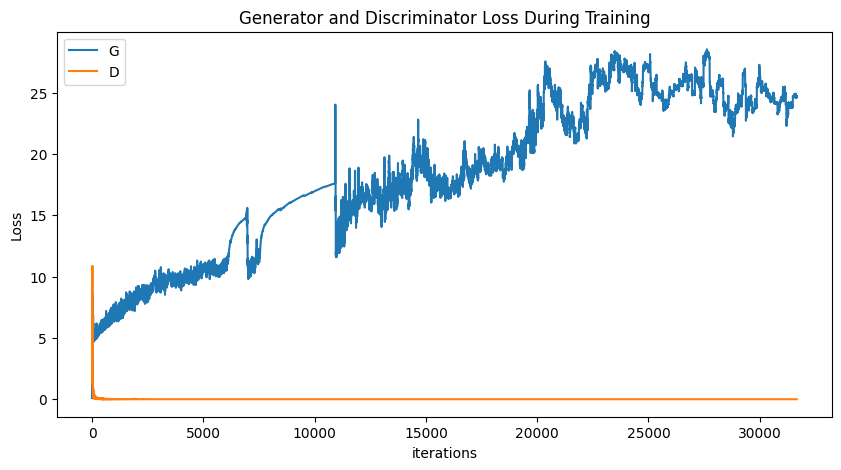

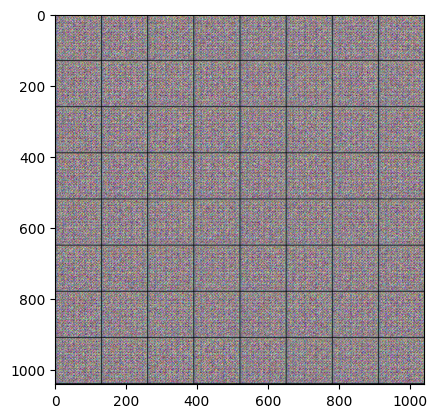

In [19]:
netG1, netD1 = initialize()
vizualize(G_losses1, D_losses1, fixed_noise1, netG1)

#### Experiment 2.
уменьшить количество сверток в дискриминаторе, заменив один из слоев на AvgPool2d. 
Меньшая по размеру модель должна слабее переобучаться.

In [20]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            nn.Conv2d(nc, ndf*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf*2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.AvgPool2d(4, 2, 1),
            nn.Conv2d(ndf*2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 8, ndf * 16, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 16),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 16, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [ ]:
fixed_noise2, img_list2, G_losses2, D_losses2, net_G2 = train_gan(2, criterion=nn.BCELoss(), 
                                                      lr_g=0.0001, lr_d=0.00003, 
                                                      batch_size=64, num_epochs=10)

Initialization successful
Starting Training Loop...
[0/10][0/3166]	Loss_D: 2.2764	Loss_G: 1.8759	D(x): 0.1685	D(G(z)): 0.2011 / 0.1725
[0/10][1000/3166]	Loss_D: 0.0012	Loss_G: 7.6835	D(x): 0.9993	D(G(z)): 0.0005 / 0.0005
[0/10][2000/3166]	Loss_D: 0.0005	Loss_G: 8.3595	D(x): 0.9998	D(G(z)): 0.0002 / 0.0002
[0/10][3000/3166]	Loss_D: 0.0012	Loss_G: 8.5457	D(x): 0.9990	D(G(z)): 0.0002 / 0.0002
[1/10][0/3166]	Loss_D: 0.0003	Loss_G: 9.1884	D(x): 0.9998	D(G(z)): 0.0001 / 0.0001
[1/10][1000/3166]	Loss_D: 0.0006	Loss_G: 8.1399	D(x): 0.9998	D(G(z)): 0.0004 / 0.0003


In [ ]:
vizualize(G_losses2, D_losses2, fixed_noise2, net_G2)

#### Experiment 3.
функции активации в блоке CSPup на LeakyReLU

In [ ]:
class CSPup(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=4, stride=2, padding=1):
        super().__init__()
        self.kernel_size =kernel_size
        self.stride = stride
        self.padding = padding
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.split_channels = self.in_channels//2
        self.left = nn.Sequential(
            nn.ConvTranspose2d(self.split_channels, self.out_channels, self.kernel_size, self.stride, self.padding, bias=False)
        )
        self.right = nn.Sequential(
            nn.Conv2d(self.split_channels, self.out_channels , 1, 1, 0),
            nn.BatchNorm2d(self.out_channels),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(self.out_channels, self.out_channels , self.kernel_size, self.stride, self.padding, bias=False),
            nn.Conv2d(self.out_channels, self.out_channels , 1, 1, 0),
            nn.BatchNorm2d(self.out_channels),
            nn.LeakyReLU(0.2),
            nn.Conv2d(self.out_channels, self.out_channels, 1, 1, 0),
        )
    def forward(self, x):
        x1 = x[:, :self.split_channels, ...]
        x2 = x[:, self.split_channels:, ...]
        y = self.left(x1)+self.right(x2)
        return y
    
    
class Generator(nn.Module):
    def __init__(self, ngpu):
        super().__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            CSPup(nz, ngf * 16, 4, 1, 0),
            CSPup(ngf * 16, ngf * 8, 4, 2, 1),
            CSPup(ngf * 8, ngf * 4, 4, 2, 1),
            CSPup(ngf * 4, ngf * 2, 4, 2, 1),
            CSPup(ngf * 2, ngf, 4, 2, 1),
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)
    
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf*2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 8, ndf * 16, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 16),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 16, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [ ]:
fixed_noise3, img_list3, G_losses3, D_losses3, net_G3 = train_gan(3, criterion=nn.BCELoss(), 
                                                      lr_g=0.0001, lr_d=0.0001, 
                                                      batch_size=64, num_epochs=10)

In [ ]:
vizualize(G_losses3, D_losses3, fixed_noise3, net_G3)

#### Experiment 4.
batch_size = 256, LEARNING_RATE_G = 1e-4, LEARNING_RATE_D = 1e-4, 15 epochs

In [ ]:
dataloader = DataLoader(dataset, batch_size=256,shuffle=True, num_workers=4)

In [ ]:
class CSPup(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=4, stride=2, padding=1):
        super().__init__()
        self.kernel_size =kernel_size
        self.stride = stride
        self.padding = padding
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.split_channels = self.in_channels//2
        self.left = nn.Sequential(
            nn.ConvTranspose2d(self.split_channels, self.out_channels, self.kernel_size, self.stride, self.padding, bias=False),
        )
        self.right = nn.Sequential(
            nn.Conv2d(self.split_channels, self.out_channels , 1, 1, 0),
            nn.ReLU(),
            nn.ConvTranspose2d(self.out_channels, self.out_channels , self.kernel_size, self.stride, self.padding, bias=False),
            nn.Conv2d(self.out_channels, self.out_channels , 1, 1, 0),
            nn.ReLU(),
            nn.Conv2d(self.out_channels, self.out_channels, 1, 1, 0),
        )
    def forward(self, x):
        x1 = x[:, :self.split_channels, ...]
        x2 = x[:, self.split_channels:, ...]
        y = self.left(x1)+self.right(x2)
        return y
    
class Generator(nn.Module):
    def __init__(self, ngpu):
        super().__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            CSPup(nz, ngf * 16, 4, 1, 0),
            CSPup(ngf * 16, ngf * 8, 4, 2, 1),
            CSPup(ngf * 8, ngf * 4, 4, 2, 1),
            CSPup(ngf * 4, ngf * 2, 4, 2, 1),
            CSPup(ngf * 2, ngf, 4, 2, 1),
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

In [ ]:
fixed_noise4, img_list4, G_losses4, D_losses4, net_G4 = train_gan(4vizualize(G_losses4, D_losses4, fixed_noise4), criterion=nn.BCELoss(), 
                                                      lr_g=1e-4, lr_d=1e-4, 
                                                      batch_size=256, num_epochs=15)

In [ ]:
vizualize(G_losses4, D_losses4, fixed_noise4, net_G4)

#### Experiment 5.
batch_size = 256 + leakyrelu + avgpool2d + 15 epochs

In [ ]:
class CSPup(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=4, stride=2, padding=1):
        super().__init__()
        self.kernel_size =kernel_size
        self.stride = stride
        self.padding = padding
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.split_channels = self.in_channels//2
        self.left = nn.Sequential(
            nn.ConvTranspose2d(self.split_channels, self.out_channels, self.kernel_size, self.stride, self.padding, bias=False)
        )
        self.right = nn.Sequential(
            nn.Conv2d(self.split_channels, self.out_channels , 1, 1, 0),
            nn.BatchNorm2d(self.out_channels),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(self.out_channels, self.out_channels , self.kernel_size, self.stride, self.padding, bias=False),
            nn.Conv2d(self.out_channels, self.out_channels , 1, 1, 0),
            nn.BatchNorm2d(self.out_channels),
            nn.LeakyReLU(0.2),
            nn.Conv2d(self.out_channels, self.out_channels, 1, 1, 0),
        )
    def forward(self, x):
        x1 = x[:, :self.split_channels, ...]
        x2 = x[:, self.split_channels:, ...]
        y = self.left(x1)+self.right(x2)
        return y
    
    
class Generator(nn.Module):
    def __init__(self, ngpu):
        super().__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            CSPup(nz, ngf * 16, 4, 1, 0),
            CSPup(ngf * 16, ngf * 8, 4, 2, 1),
            CSPup(ngf * 8, ngf * 4, 4, 2, 1),
            CSPup(ngf * 4, ngf * 2, 4, 2, 1),
            CSPup(ngf * 2, ngf, 4, 2, 1),
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)
    
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            nn.Conv2d(nc, ndf*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf*2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.AvgPool2d(4, 2, 1),
            nn.Conv2d(ndf*2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 8, ndf * 16, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 16),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 16, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [ ]:
fixed_noise5, img_list5, G_losses5, D_losses5, net_G5 = train_gan(5, criterion=nn.BCELoss(), 
                                                      lr_g=1e-4, lr_d=1e-4, 
                                                      batch_size=256, num_epochs=15)

In [ ]:
vizualize(G_losses5, D_losses5, fixed_noise5, net_G5)